ZINC20 Library

In [2]:
import pandas as pd

df = pd.read_csv('data/sanity_report.tsv', sep='\t')
#mask = (df["PAINS"].values == "NO") & (df["REACTIVE_GROUPS"].values == "NONE") & (df["AGGREGATOR_FLAGS"].values == "NONE")

clean_molecules = df[["SMILES", "ZINC_ID"]].drop_duplicates()
print(clean_molecules.shape)

(9133912, 2)


In [3]:
print(clean_molecules["ZINC_ID"].nunique())
print(clean_molecules["SMILES"].nunique())

9133912
9131118


In [5]:
unique_smiles_df = clean_molecules.drop_duplicates(subset="SMILES")
print(unique_smiles_df.shape)
unique_smiles_df.head()

(9131118, 2)


,SMILES,ZINC_ID
0,C[S@@](=O)CC(N)=O,34310585
1,CO[C@H]1OC[C@@H](O)[C@H](O)[C@H]1O,4371221
2,NCc1cc(=O)[nH]c(O)n1,26507110
3,CS(=O)(=O)CCCNN,63014624
4,NC(=O)[C@H]1[C@H]2C=C[C@@H](O2)[C@@H]1N,242677143


In [6]:
print(unique_smiles_df["ZINC_ID"].nunique())
print(unique_smiles_df["SMILES"].nunique())

9131118
9131118


In [7]:
SAMPLE_SIZE = 200

df_sample = unique_smiles_df.sample(n=SAMPLE_SIZE, random_state=42)

df_sample.reset_index(drop=True, inplace=True)

In [8]:
#df_sample = df_sample.head(100000)
df_sample.to_csv("data/sample_2k_library.csv", index=False)

Enamine Real HLL-100 (100k) Library

In [41]:
import pandas as pd

df = pd.read_csv('data/enamine_hll_100k.csv', header=1)
#mask = (df["PAINS"].values == "NO") & (df["REACTIVE_GROUPS"].values == "NONE") & (df["AGGREGATOR_FLAGS"].values == "NONE")

df.head()

,SMILES,Catalog ID,MW,MW (desalted),ClogP,logS,HBD,HBA,TPSA,RotBonds,AnalogsFromREAL
0,Cl.NCC(C1=CNC=2C=CC=CC12)C=3C=CC=CC3Cl,Z57988914,307.217,270.757,3.574,-4.800,2,1,41.81,3,https://real.enamine.net/public-enum-files/Z57...
1,CC=1C=CC=C(C1)CC2=NOC(=N2)C3=CC(C#N)=CN3,Z1683335414,264.283,264.283,2.997,-3.569,1,3,78.50,3,https://real.enamine.net/public-enum-files/Z16...
2,CC=1C=CC=2N=C(SC2C1)C=3C=CC(=CC3)NC(=O)CSC4=NC...,Z56838658,408.500,408.500,3.136,-7.440,2,4,83.45,5,https://real.enamine.net/public-enum-files/Z56...
3,CC(C)C1=NOC(=N1)C=2C=CC(=CC2)NC(=O)N3CCOCC3,Z1117060619,316.356,316.356,1.715,-3.748,1,4,80.49,5,https://real.enamine.net/public-enum-files/Z11...
4,FC(F)(F)C=1C=CC=C(C1)CSC2=NN=C(O2)C3=CC=CN3,Z98928949,325.311,325.311,3.004,-5.770,1,2,54.71,5,https://real.enamine.net/public-enum-files/Z98...


In [4]:
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize

def sanitize_smiles(smiles):
    if not isinstance(smiles, str): return None
    try:
        mol = Chem.MolFromSmiles(smiles)
        if not mol: return None
        
        # Standardize
        clean_mol = rdMolStandardize.Cleanup(mol)
        lfc = rdMolStandardize.LargestFragmentChooser()
        mol = lfc.choose(clean_mol)
        uncharger = rdMolStandardize.Uncharger()
        mol = uncharger.uncharge(mol)
        te = rdMolStandardize.TautomerEnumerator()
        mol = te.canonicalize(mol)
        
        return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
    except:
        return None

In [42]:
import datamol as dm
import tqdm

# This one line replaces your entire function and handles parallelization
df["clean_smiles"] = dm.parallelized(dm.standardize_smiles, df["SMILES"].values, n_jobs=-1)

In [43]:
df["clean_mols"] = dm.parallelized(dm.to_mol, df["clean_smiles"].values, n_jobs=-1)

In [44]:
#calculated values were different, drop original

df = df.drop(columns=["MW", "MW (desalted)", "ClogP", "HBD", "HBA", "TPSA"])

In [45]:
import datamol as dm
import pandas as pd
from rdkit.Chem import rdMolDescriptors, Crippen, Lipinski, QED

def get_extended_descriptors(mol):
    """Function to calculate 8 descriptors for a single molecule."""
    if mol is None:
        return {col: None for col in ["MW", "ClogP", "TPSA", "HBD", "HBA", "QED", "FractionCsp3", "NumAromaticRings"]}
    
    return {
        "MW": rdMolDescriptors.CalcExactMolWt(mol),
        "ClogP": Crippen.MolLogP(mol),
        "TPSA": rdMolDescriptors.CalcTPSA(mol),
        "HBD": Lipinski.NumHDonors(mol),
        "HBA": Lipinski.NumHAcceptors(mol),
        "QED": QED.qed(mol),
        "FractionCsp3": rdMolDescriptors.CalcFractionCSP3(mol),
        "NumAromaticRings": Lipinski.NumAromaticRings(mol)
    }

# Run parallel processing on the column containing RDKit Mol objects
# Ensure df["clean_mols"] contains the standardized molecules from earlier
results = dm.parallelized(get_extended_descriptors, df["clean_mols"].values, n_jobs=-1)

# Merge back to the main dataframe
desc_df = pd.DataFrame(results)
df = pd.concat([df, desc_df], axis=1)

In [ ]:
df["HBD_HBA"] = df["HBD"] + df["HBA"]
descriptors = ["MW", "ClogP", "TPSA", "HBD", "HBA", "QED", "FractionCsp3", "NumAromaticRings"]
print("Missing values per column:")
print(df[descriptors].isna().sum())

Missing values per column:
MW                  0
ClogP               0
TPSA                0
HBD                 0
HBA                 0
QED                 0
FractionCsp3        0
NumAromaticRings    0
dtype: int64


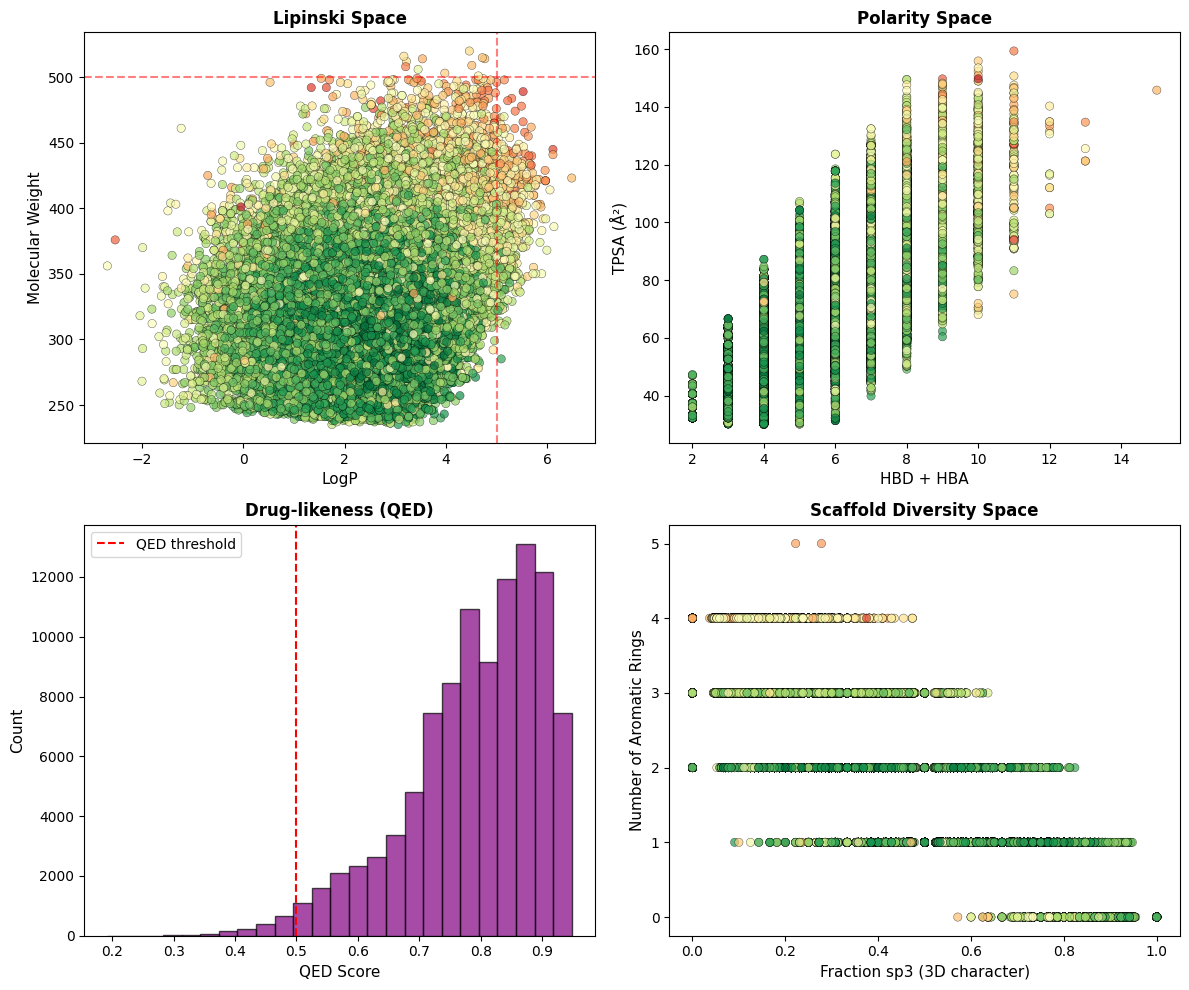

In [47]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# ============================================================
# CHEMICAL SPACE VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# MW vs LogP (Lipinski space)
ax1 = axes[0, 0]
scatter = ax1.scatter(df['ClogP'], df['MW'],
                      c=df['QED'],
                      cmap='RdYlGn',
                      alpha=0.7, edgecolor='k', linewidth=0.3)
ax1.axhline(y=500, color='red', linestyle='--', alpha=0.5, label='Lipinski MW')
ax1.axvline(x=5, color='red', linestyle='--', alpha=0.5, label='Lipinski LogP')
ax1.set_xlabel('LogP', fontsize=11)
ax1.set_ylabel('Molecular Weight', fontsize=11)
ax1.set_title('Lipinski Space', fontsize=12, fontweight='bold')

# TPSA vs HBD+HBA
ax2 = axes[0, 1]
df['HB_total'] = df['HBD'] + df['HBA']
scatter2 = ax2.scatter(df['HB_total'], df['TPSA'],
                        cmap='RdYlGn',
                        c=df['QED'],
                       alpha=0.7, edgecolor='k', linewidth=0.3)
ax2.set_xlabel('HBD + HBA', fontsize=11)
ax2.set_ylabel('TPSA (Å²)', fontsize=11)
ax2.set_title('Polarity Space', fontsize=12, fontweight='bold')

# QED distribution
ax3 = axes[1, 0]
ax3.hist(df['QED'], bins=25, edgecolor='black', alpha=0.7, color='purple')
ax3.axvline(x=0.5, color='red', linestyle='--', label='QED threshold')
ax3.set_xlabel('QED Score', fontsize=11)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('Drug-likeness (QED)', fontsize=12, fontweight='bold')
ax3.legend()

ax4 = axes[1, 1]  # e.g., bottom-right panel

scatter = ax4.scatter(df['FractionCsp3'],
                      df['NumAromaticRings'],
                      c=df['QED'],
                      cmap='RdYlGn',
                      alpha=0.7, edgecolor='k', linewidth=0.3)

ax4.set_xlabel('Fraction sp3 (3D character)', fontsize=11)
ax4.set_ylabel('Number of Aromatic Rings', fontsize=11)
ax4.set_title('Scaffold Diversity Space', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/chemical_space.png', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
df.head()

,SMILES,Catalog ID,logS,RotBonds,AnalogsFromREAL,clean_smiles,clean_mols,MW,ClogP,TPSA,HBD,HBA,QED,FractionCsp3,NumAromaticRings,HBD_HBA,HB_total
0,Cl.NCC(C1=CNC=2C=CC=CC12)C=3C=CC=CC3Cl,Z57988914,-4.800,3,https://real.enamine.net/public-enum-files/Z57...,Cl.NCC(c1ccccc1Cl)c1c[nH]c2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x130c4bd80>,306.069054,4.33370,41.81,2,1,0.742608,0.125000,3,3,3
1,CC=1C=CC=C(C1)CC2=NOC(=N2)C3=CC(C#N)=CN3,Z1683335414,-3.569,3,https://real.enamine.net/public-enum-files/Z16...,Cc1cccc(Cc2noc(-c3cc(C#N)c[nH]3)n2)c1,<rdkit.Chem.rdchem.Mol object at 0x13d840db0>,264.101111,2.83560,78.50,1,4,0.788507,0.133333,3,5,5
2,CC=1C=CC=2N=C(SC2C1)C=3C=CC(=CC3)NC(=O)CSC4=NC...,Z56838658,-7.440,5,https://real.enamine.net/public-enum-files/Z56...,Cc1ccc2nc(-c3ccc(NC(=O)CSc4nccc(=O)[nH]4)cc3)s...,<rdkit.Chem.rdchem.Mol object at 0x13d842c50>,408.071468,4.08582,87.74,2,6,0.383642,0.100000,4,8,8
3,CC(C)C1=NOC(=N1)C=2C=CC(=CC2)NC(=O)N3CCOCC3,Z1117060619,-3.748,5,https://real.enamine.net/public-enum-files/Z11...,CC(C)c1noc(-c2ccc(NC(=O)N3CCOCC3)cc2)n1,<rdkit.Chem.rdchem.Mol object at 0x13d843560>,316.153541,2.72410,80.49,1,5,0.941413,0.437500,2,6,6
4,FC(F)(F)C=1C=CC=C(C1)CSC2=NN=C(O2)C3=CC=CN3,Z98928949,-5.770,5,https://real.enamine.net/public-enum-files/Z98...,FC(F)(F)c1cccc(CSc2nnc(-c3ccc[nH]3)o2)c1,<rdkit.Chem.rdchem.Mol object at 0x13d842b60>,325.049668,4.37580,54.71,1,4,0.723517,0.142857,3,5,5


In [51]:
# Select, rename, and save
df[["clean_smiles", "Catalog ID"]].rename(
    columns={"clean_smiles": "SMILES", "Catalog ID": "ID"}
).to_csv("data/enamine_real_clean.csv", index=False)

In [2]:
import pandas as pd
df = pd.read_csv("data/enamine_real_clean.csv")

In [3]:
df.head(20001)

,SMILES,ID
0,Cl.NCC(c1ccccc1Cl)c1c[nH]c2ccccc12,Z57988914
1,Cc1cccc(Cc2noc(-c3cc(C#N)c[nH]3)n2)c1,Z1683335414
2,Cc1ccc2nc(-c3ccc(NC(=O)CSc4nccc(=O)[nH]4)cc3)s...,Z56838658
3,CC(C)c1noc(-c2ccc(NC(=O)N3CCOCC3)cc2)n1,Z1117060619
4,FC(F)(F)c1cccc(CSc2nnc(-c3ccc[nH]3)o2)c1,Z98928949
...,...,...
19996,Cc1ccc2cc(CN3C[C@H](F)C[C@H]3C(=O)N3CCOCC3)ccc2n1,Z2054576697
19997,NC(=O)[C@@H]1C[C@@H](F)CN1Cc1c[nH]nc1-c1c(F)cc...,Z2054556772
19998,COc1ccccc1C(C)NC(=O)c1sc(-c2ccccn2)nc1C,Z99354956
19999,CN(C)C(=O)COc1ccccc1C(=O)Nc1cccc(OC(F)(F)F)c1,Z284673550


In [4]:
df.head(20001).to_csv("data/enamine_real_20k.csv", index=False)